In [ ]:
# This program was used to produce the plots for Figure 3.

In [1]:
using Distributions
using Plots
using Random
default(fmt = :png)

In [2]:
function simpler_jump(x, y, a = 1)
    theta = rand(Uniform(0, 2 * π))
    u = rand(Uniform(0, 1))

    r = a/(3 * u)^(1/3)

    xfl = r * sin(theta)
    yfl = r * cos(theta)

    (floor(Int, x + xfl + 1/2),
    floor(Int, y + yfl + 1/2), r)
end

function gridoffsetandsize(infectors, removed, susceptibles)
    xoffset = yoffset = 0

    data = vcat(infectors, removed, susceptibles)

    xcoords = map(x -> x[1], data)
    ycoords = map(x -> x[2], data)

    (xmin, xmax) = (minimum(xcoords), maximum(xcoords))
    (ymin, ymax) = (minimum(ycoords), maximum(ycoords))

    if xmin < 1
        xoffset = abs(xmin)
    end

    if ymin < 1
        yoffset = abs(ymin)
    end

    gridsize = max(xmax + xoffset, ymax + yoffset)

    # add 1 because you need to include the point 0
    (xoffset + 1, yoffset + 1, gridsize + 1)
end

function creategrid(infectors, removed, visited, xoffset, yoffset, gridsize)
    grid = zeros(gridsize, gridsize)

    infector_coords = map(x -> x[1:2], infectors)
    removed_coords = map(x -> x[1:2], removed)
    visited_coords = map(x -> x[1:2], visited)
    
    for (x, y) in visited_coords
        grid[x + xoffset, y + yoffset] = 1
    end

    for (x, y) in removed_coords
        grid[x + xoffset, y + yoffset] = 2
    end

    for (x, y) in infector_coords
        grid[x + xoffset, y + yoffset] = 3
    end
    
    if !(1 in grid)
        for (x, y) in removed_coords
            grid[x + xoffset, y + yoffset] = 1
        end

        for (x, y) in infector_coords
            grid[x + xoffset, y + yoffset] = 2
        end
    end

    grid
end

function visualizegrid(grid, time)
    if 1 in grid && 2 in grid && 3 in grid
        colorgradient = cgrad([:black, :blue, :white, :red])
    elseif 1 in grid && 2 in grid
        colorgradient = cgrad([:black, :white, :red])
    else
        colorgradient = cgrad([:black, :white])
    end

    heatmap(1:size(grid, 1),
            1:size(grid, 2),
            grid,
            legend = :none,
            title="Time step $(time).",
            c = colorgradient,
            size=(650, 600), colorbar = false)
end

function probinfected(x, p1, p2)
    if x <= 0 
        return p1
    else
        return p2
    end
end

function outbreakwithjumps_varp(maxtime :: Int,
                           maxtau :: Int,
                           nextstepfcn :: Function,
                           probinfected :: Function,
                           p_arr :: Array{Float64, 1},
                           graphcapturetimes :: Array{Int, 1},
                           maxgridsize :: Int,
                           initialinfectors,
                           addinfectors = true) :: Tuple{Array{Int, 1},
                                                   Array{Array{Int}, 1},
                                                   Array{Array{Int}, 1},
                                                   Array{Any, 1},
                                                   Array{Int64, 1},
                                                   Array{Int64, 1}, 
                                                   Array{Int64, 1}}
    # Tracking the different agents
    x_start = 0
    y_start = 0

    newinfections = Array{Int64, 1}()
    infectors = initialinfectors
    numinfected = [length(infectors)]
    removed = Set([[x_start, y_start]])
    visited = Set([[x_start, y_start]])
    numvisited = zeros(Int, maxtime)
    numsusceptiblesvisited = zeros(Int, maxtime)
    r_inf = Array{Tuple{Int64, Int64}, 1}()
    graphcomponents = Array{Any, 1}()
    

    for time in 1:maxtime
        ninfectors = length(infectors)
        ninfected = 0
        newinfections_now = 0
        
        if time != 1
            numvisited[time] = numvisited[time - 1]
            numsusceptiblesvisited[time] = numsusceptiblesvisited[time - 1]
        end

        for i in 1:ninfectors
            infector = infectors[i]
            (infector[1], infector[2]) = simpler_jump(infector[1], infector[2])
            infector[3] += 1

            inremoved = infector[1:2] in removed
            alreadyvisited = infector[1:2] in visited
            
            if !alreadyvisited
                push!(visited, infector[1:2])
                numvisited[time] += 1
            end
            
            isinfecting = rand() <= probinfected(infector[1], p_arr[1], p_arr[2])
            
            if !alreadyvisited && !isinfecting
                numsusceptiblesvisited[time] += 1
            end
            
            if !inremoved && isinfecting && alreadyvisited
                numsusceptiblesvisited[time] -= 1
            end
            
            if !inremoved && isinfecting
                push!(removed, infector[1:2])
            end

            if !inremoved && isinfecting
                newinfections_now += 1
                if !addinfectors
                    ninfected += 1
                else
                    push!(infectors, [infector[1:2]..., 0, 0])
            end

                infector[4] += 1
            end
        end
        
        push!(newinfections, newinfections_now)

        infectedtoremove = filter(x -> x[3] >= maxtau, infectors)
        for infector in infectedtoremove
            push!(r_inf, (infector[4], time))
        end

        filter!(x -> x[3] < maxtau, infectors)

        if addinfectors
            push!(numinfected, length(infectors))
        else
            push!(numinfected, ninfected)
        end
        
        if time in graphcapturetimes
            push!(graphcomponents, [copy(time), deepcopy(infectors), collect(removed), collect(visited)])
        end
    end
    
    
    removed = collect(removed)
    graphs = Array{Any, 1}()
    for i in 1:length(graphcomponents)
        (xoffset, yoffset, gridsize) = gridoffsetandsize(graphcomponents[i][2], graphcomponents[i][3], graphcomponents[i][4])
        xoffset = round(Int, maxgridsize/2)
        yoffset = round(Int, maxgridsize/2)
        gridsize = maxgridsize
        push!(graphs, creategrid(graphcomponents[i][2], graphcomponents[i][3], graphcomponents[i][4], xoffset, yoffset, gridsize))
    end

    (numinfected, infectors, removed, graphs, newinfections, numsusceptiblesvisited, numvisited)
 
end

outbreakwithjumps_varp (generic function with 2 methods)

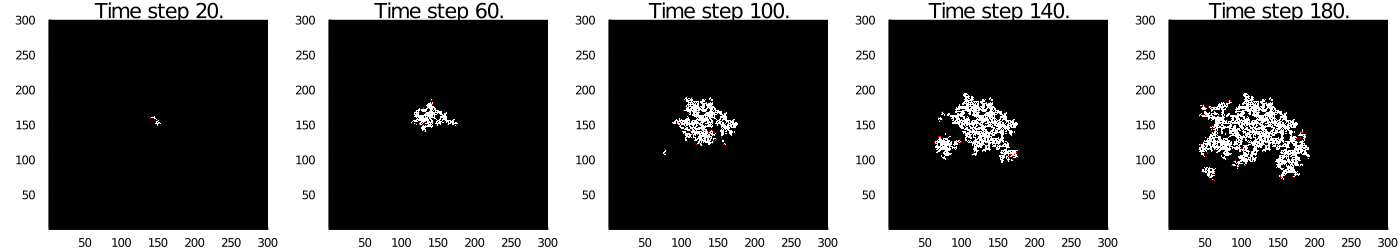

In [4]:
# Generate a plot with the same τ and p inputs as Figure 3a

maxtime = 200
times = map(x -> x, 20:40:maxtime)
# p_arr: [p in the left region (x <= 0), p in the right region]
p_arr = [1.0, 1.0] 
τ = 2
maxgridsize = 300
initialinfectors = [[0, 0, 0, 0]]

(infections, infectors, removed, graphs, newinfections) = 
    outbreakwithjumps_varp(maxtime, τ, simpler_jump, probinfected, p_arr, times, maxgridsize, initialinfectors)

plots = Array{Any, 1}()
for (idx, time) in enumerate(times)
    push!(plots, visualizegrid(graphs[idx], time))
end

p1 = plot(plots..., size=(1400, 250), layout=(1,length(times)))

plot(p1)

In [ ]:
# Generate a plot with the same τ and p inputs as Figure 3b

maxtime = 200
times = map(x -> x, 20:40:maxtime)
# p_arr: [p in the left region (x <= 0), p in the right region]
p_arr = [1/8, 1/8] 
τ = 16
maxgridsize = 300
initialinfectors = [[0, 0, 0, 0]]

(infections, infectors, removed, graphs, newinfections) = 
    outbreakwithjumps_varp(maxtime, τ, simpler_jump, probinfected, p_arr, times, maxgridsize, initialinfectors)

plots = Array{Any, 1}()
for (idx, time) in enumerate(times)
    push!(plots, visualizegrid(graphs[idx], time))
end

p1 = plot(plots..., size=(1400, 250), layout=(1,length(times)))

plot(p1)

In [ ]:
# Generate a plot with the same τ and p inputs as Figure 3c

maxtime = 200
times = map(x -> x, 20:40:maxtime)
# p_arr: [p in the left region (x <= 0), p in the right region]
p_arr = [1/64, 1/64] 
τ = 122
maxgridsize = 300
initialinfectors = [[0, 0, 0, 0]]

(infections, infectors, removed, graphs, newinfections) = 
    outbreakwithjumps_varp(maxtime, τ, simpler_jump, probinfected, p_arr, times, maxgridsize, initialinfectors)

plots = Array{Any, 1}()
for (idx, time) in enumerate(times)
    push!(plots, visualizegrid(graphs[idx], time))
end

p1 = plot(plots..., size=(1400, 250), layout=(1,length(times)))

plot(p1)